# Group Number:
# Student 1:
# Student 2:
# Student 3:

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
notebook_dir = "/content/drive/MyDrive/TUe/DeepLearning"

In [2]:
""" # # UNCOMMENT IF USING COLAB
from google.colab import drive
import requests
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir) 
os.chdir(notebook_dir)
symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
r_s = requests.get(symco, allow_redirects=True)
r_c = requests.get(crpt, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)
with open('carpet.py', 'wb') as f:
    f.write(r_c.content) """

' # # UNCOMMENT IF USING COLAB\nfrom google.colab import drive\nimport requests\ndrive.mount(\'/content/drive\')\nimport sys\nimport os\nsys.path.insert(0, notebook_dir) \nos.chdir(notebook_dir)\nsymco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"\ncrpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"\nr_s = requests.get(symco, allow_redirects=True)\nr_c = requests.get(crpt, allow_redirects=True)\nwith open(\'symconv.py\', \'wb\') as f:\n    f.write(r_s.content)\nwith open(\'carpet.py\', \'wb\') as f:\n    f.write(r_c.content) '

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

In [5]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [6]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Convolushahr


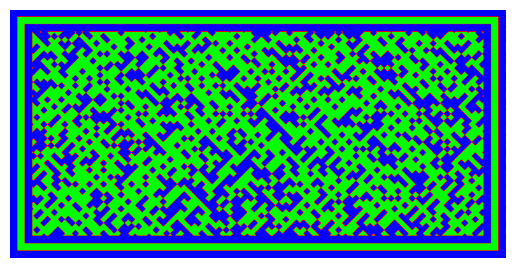

In [7]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
        
class SymModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.rot_slc = sc.Slice(rotation=4, reflection=False)
        self.convs = nn.Sequential(
            sc.SymmetryConv2d(in_filters=1, out_filters=16, kernel_size=4, stride=4, rotation=4, reflection=False),
            nn.ReLU(),
            sc.SymmetryPool(),
            nn.Conv2d(16, 32, kernel_size=3, stride=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            Lambda(lambda x: x.view(x.size(0), -1))
            )
        # self.pool = sc.SymmetryPool()
                    
        # self.view = Lambda(lambda x: x.view(x.size(0), -1))
        self.lin1 = nn.Linear(576, 576)
        self.lin2 = nn.Linear(576, 64)
        self.lin3 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = self.rot_slc(x)
        x = self.convs(x)

        # x = torch.flatten(x, start_dim=1)
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)

        return x

In [10]:
model = SymModel().to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

In [74]:
EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
    
    model.train()
    
    train_losses = []

    train_acc, train_count = 0, 0

    for batch in train_dataloader:
        x, y = batch
        input, labels = x.to(device), y.to(device)
        optimizer.zero_grad()

        output = model(input)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        train_acc += (labels.argmax(dim=-1) == output.argmax(dim=-1)).sum().item()

        train_count += labels.size(0)

    model.eval()

    valid_acc, valid_count = 0, 0


    for batch in valid_dataloader:

        x, y = batch
        input, labels = x.to(device), y.to(device)

        with torch.no_grad():
            output = model(input)
            
            valid_acc += (labels.argmax(dim=-1) == output.argmax(dim=-1)).sum().item()

            valid_count += labels.size(0)



    print(f'Train acc: {train_acc / train_count:.4f}',end=' ')
    print(f'Val acc: {valid_acc / valid_count:.4f}',end='\n')

 10%|█         | 1/10 [00:13<01:58, 13.19s/it]

Train acc: 0.3583 Val acc: 0.4490


 20%|██        | 2/10 [00:25<01:42, 12.86s/it]

Train acc: 0.4920 Val acc: 0.6410


 30%|███       | 3/10 [00:39<01:31, 13.04s/it]

Train acc: 0.7968 Val acc: 0.9020


 40%|████      | 4/10 [00:51<01:17, 12.87s/it]

Train acc: 0.9440 Val acc: 0.9530


 50%|█████     | 5/10 [01:11<01:17, 15.44s/it]

Train acc: 0.9767 Val acc: 0.9765


 60%|██████    | 6/10 [01:28<01:03, 15.88s/it]

Train acc: 0.9877 Val acc: 0.9675


 70%|███████   | 7/10 [01:43<00:47, 15.73s/it]

Train acc: 0.9936 Val acc: 0.9745


 80%|████████  | 8/10 [01:59<00:31, 15.65s/it]

Train acc: 0.9953 Val acc: 0.9895


 90%|█████████ | 9/10 [02:15<00:15, 15.89s/it]

Train acc: 0.9972 Val acc: 0.9875


100%|██████████| 10/10 [02:28<00:00, 14.85s/it]

Train acc: 0.9989 Val acc: 0.9875


In [12]:
model_task1_state = model.state_dict()

## Task 1: Question 5d

# Task 2: Carpet Matching 

In [13]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [14]:
torch.manual_seed(7)
np.random.seed(7)

In [15]:
#Stratify split into train and validation
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0, stratify=y)

#convert to tensors
X_train = torch.tensor(X).float()
y_train = y
# X_val = torch.tensor(X_val).float()

#### Defining the Embedding Net. Using the same network from Task 1 ## 

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, lambd):
        super().__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.rot_slc = sc.Slice(rotation=4, reflection=False)
        self.convs = nn.Sequential(
            sc.SymmetryConv2d(in_filters=1, out_filters=16, kernel_size=4, stride=4, rotation=4, reflection=False),
            nn.ReLU(),
            sc.SymmetryPool(),
            nn.Dropout(p=0.4),
            nn.Conv2d(16, 32, kernel_size=3, stride=3),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            Lambda(lambda x: x.view(x.size(0), -1))
            )

        self.lin1 = nn.Linear(576, 576)  #second to last layer of model of task 1 to extract embeddings 
        # self.lin2 = nn.Linear(576, 64)
        
        
    def forward(self, x):
        x = self.rot_slc(x)
        x = self.convs(x)
        # x = torch.flatten(x, start_dim=1)
        x = self.lin1(torch.flatten(x, start_dim=1))
        # x = self.lin2(x)

        return x
    
    def get_embedding(self, x):
        return self.forward(x)



### Balanced Batch Sampler and Data Loader

In [38]:
from torch.utils.data.sampler import BatchSampler
import numpy as np

class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """
    #Just overriding a bunch of methods from BatchSampler

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [39]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [40]:
train_batch_sampler = BalancedBatchSampler(y_train, n_classes=200, n_samples=10)
# test_batch_sampler = BalancedBatchSampler(y_val, n_classes=200, n_samples=2)

#train_dataset= torch.utils.data.TensorDataset(X_train,y_train)
#test_dataset= torch.utils.data.TensorDataset(X_val,y_val)
train_dataset = CustomDataset(X_train, y_train)
# test_dataset = CustomDataset(X_val, y_val)

triplets_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
# triplets_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler)

### All pair Selector

In [182]:
from itertools import combinations

class PairSelector():
    """
    Select each possible pair
    """

    def __init__(self):
        super(PairSelector, self).__init__()

    def get_doubles(self, embeddings, labels):
        
        return embeddings,  labels


### Contrastive loss

In [183]:
#Helper function to compute Euclidean distance

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [184]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin, pair_selector, average):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9
        self.pair_selector  = pair_selector
        self.average = average
 
    def forward(self, embeddings, labels, average = True):
        # embeddings = torch.stack(embeddings)
        # distance_matrix = pdist(embeddings)
        embeddings, labels = self.pair_selector.get_doubles(embeddings, labels) 
        D = labels.unsqueeze(0) == labels.unsqueeze(1)
        D = D.float()

        losses = torch.tril(pdist(embeddings))*D + (1-D)*torch.tril(torch.clamp_min(margin - pdist(embeddings), 0))
        
        # for label in set(labels):
        #     targets = [] * len(labels)

        #     label_mask = (labels == label)
        #     label_indices = np.where(label_mask)[0]
        #     targets = [1 if i in label_indices else 0 for i in range(targets)]

        #     if len(label_indices)<2:
        #         continue
        #     negative_indices = np.where(np.logical_not(label_mask))[0]
        #     pos
        # embeddings = 
        # distances = pdist(output1 - output2)
        return losses.mean() if self.average else losses.sum()


### Training the model

In [185]:
class Train():
    def __init__(self,
                 model: nn.Module,
                 device: torch.device,
                 criterion: nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.DataLoader,
                 epochs: int,
                ):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        # self.validation_DataLoader = validation_DataLoader
        self.epochs = epochs

    def run_train(self):

        for epoch in tqdm(range(self.epochs)):

            self.model.train()

            train_losses = []
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  
            # evaluation mode
            # valid_losses = []  # accumulate the losses here

            # for batch in self.validation_DataLoader:

            #     x,y=batch
            #     input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            #     with torch.no_grad():
            #         out = self.model(input)   # one forward pass
            #         loss = self.criterion(out, target) # calculate loss
                 
            #         loss_value = loss.item()
            #         valid_losses.append(loss_value)


                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            # print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')
            print(f'TEST- ACC: {query_performance(queries, targets, gt, model = self.model)}',end='\n')


In [186]:
# function to determine performance of model
def query_performance(queries, targets, gt, model, top=1):
    assert top >= 1
    cnt = 0

    #convert to torch tensors
    queries= torch.tensor(queries)
    targets= torch.tensor(targets)

    q = queries.float()
    t = targets.float()

    with torch.no_grad():
        
        
        ### MODIFY IF NECESSARY ###
        #set model to evaluation mode
        model.eval()

        #For each query, compute embeddings for both query and 4 targets and store them in the most efficient way
        emb_q = model(q).cpu().numpy()
        emb_t=np.empty((len(queries),1,4,576)) #embedding shape
        for i in range(len(queries)):
            emb_t_ind=model(t[i]).cpu().numpy()
            emb_t_ind = np.expand_dims(emb_t_ind, axis=0)
            emb_t[i]=emb_t_ind
                
        for i in range(len(queries)):  
            dist = cdist(np.expand_dims(emb_q[i],axis=0), np.concatenate(emb_t[i]))
        
            if top == 1:
                pred = np.argmin(dist)
                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dist)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1       

    return (100*cnt/gt.shape[0])

In [187]:
#for reproducability
torch.manual_seed(7)
np.random.seed(7)

In [188]:
if torch.cuda.is_available():
    device = torch.device('cuda')

else:
    device = torch.device('cpu')

model= EmbeddingNet().to(device)

margin = 10

criterion = ContrastiveLoss(10, PairSelector(), False)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

trainer= Train(model=model,
               device=device,
               criterion=criterion,
               optimizer=optimizer,
               training_DataLoader=triplets_train_loader,
               epochs=30)

trainer.run_train()

model_task2_state = model.state_dict()

# TripletLoss(margin,  Informative_Negative_TripletSelector(margin, 0.2))

  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH: 01/30 LOSS: 744501.8750 

  3%|▎         | 1/30 [00:25<12:06, 25.04s/it]

TEST- ACC: 31.333333333333332
EPOCH: 02/30 LOSS: 291663.1496 

  7%|▋         | 2/30 [00:50<11:43, 25.13s/it]

TEST- ACC: 33.666666666666664
EPOCH: 03/30 LOSS: 389770.5848 

 10%|█         | 3/30 [01:19<12:15, 27.24s/it]

TEST- ACC: 35.666666666666664
EPOCH: 04/30 LOSS: 257632.8616 

 13%|█▎        | 4/30 [01:45<11:35, 26.75s/it]

TEST- ACC: 40.0
EPOCH: 05/30 LOSS: 176050.8058 

 17%|█▋        | 5/30 [02:10<10:52, 26.10s/it]

TEST- ACC: 42.0
EPOCH: 06/30 LOSS: 161943.0804 

 20%|██        | 6/30 [02:35<10:15, 25.65s/it]

TEST- ACC: 42.666666666666664
EPOCH: 07/30 LOSS: 169344.2522 

 23%|██▎       | 7/30 [03:00<09:44, 25.41s/it]

TEST- ACC: 43.0
EPOCH: 08/30 LOSS: 154011.9219 

 27%|██▋       | 8/30 [03:25<09:13, 25.17s/it]

TEST- ACC: 43.333333333333336
EPOCH: 09/30 LOSS: 151835.5424 

 30%|███       | 9/30 [03:49<08:45, 25.02s/it]

TEST- ACC: 42.333333333333336
EPOCH: 10/30 LOSS: 151146.9018 

 33%|███▎      | 10/30 [04:14<08:18, 24.91s/it]

TEST- ACC: 43.333333333333336
EPOCH: 11/30 LOSS: 149974.9375 

 37%|███▋      | 11/30 [04:39<07:50, 24.74s/it]

TEST- ACC: 42.0
EPOCH: 12/30 LOSS: 148606.2143 

 40%|████      | 12/30 [05:03<07:24, 24.68s/it]

TEST- ACC: 42.333333333333336
EPOCH: 13/30 LOSS: 147578.7656 

 43%|████▎     | 13/30 [05:28<07:00, 24.73s/it]

TEST- ACC: 43.0
EPOCH: 14/30 LOSS: 148075.1540 

 47%|████▋     | 14/30 [05:52<06:33, 24.59s/it]

TEST- ACC: 43.333333333333336
EPOCH: 15/30 LOSS: 146778.4062 

 50%|█████     | 15/30 [06:17<06:07, 24.53s/it]

TEST- ACC: 44.333333333333336
EPOCH: 16/30 LOSS: 146020.0647 

 53%|█████▎    | 16/30 [06:50<06:23, 27.36s/it]

TEST- ACC: 44.666666666666664
EPOCH: 17/30 LOSS: 146157.7098 

 57%|█████▋    | 17/30 [07:17<05:50, 26.96s/it]

TEST- ACC: 45.333333333333336


In [122]:
class Informative_PairSelector():

    def __init__(self, margin, loss_margin):
        super(Informative_PairSelector, self).__init__()
  
        self.margin = margin
        self.loss_margin = loss_margin


    def get_doubles(self, embeddings, labels):
        #filters embeddings based on their loss with all other pairs by taking the row sumn and filtering out embeddings which contribute to the loss in a minimal way
        #this makes sure we mine semi-hard or hard pairs based on the set threshold

        D = labels.unsqueeze(0) == labels.unsqueeze(1)
        D = D.float()

        losses = torch.tril(pdist(embeddings))*D + (1-D)*torch.tril(torch.clamp_min(margin - pdist(embeddings), 0))

        row_sum = torch.sum(losses, dim=1)
        keep_mask = torch.gt(row_sum, loss_margin)
        print(len(embeddings))
        print(len(embeddings[keep_mask]))

        return embeddings[keep_mask], labels[keep_mask]

In [117]:
model_task2_state = model.state_dict()

In [172]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device=torch.device('cpu')
    
# model
mined_embedding_net = EmbeddingNet()
mined_model = mined_embedding_net.to(device)

mined_model.load_state_dict(model_task2_state)
# margin value
margin= 5
loss_margin = 10

# criterion
criterion = ContrastiveLoss(10,  Informative_PairSelector(margin, loss_margin), False)
# optimizer
optimizer = torch.optim.Adam(mined_model.parameters(), lr=0.001)

# trainer
trainer = Train(model=mined_model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  epochs=1)

# start training
trainer.run_train()

  0%|          | 0/1 [00:00<?, ?it/s]

2000
1856
2000
1824
2000
1834
2000
1853
2000
1841
2000
1846
2000
1851
EPOCH: 1/1 LOSS: 124942.8605 

100%|██████████| 1/1 [00:26<00:00, 26.50s/it]

TEST- ACC: 73.66666666666667


In [165]:
# function to determine performance of model
def query_performance(queries, targets, gt, model, top=1):
    assert top >= 1
    cnt = 0

    #convert to torch tensors
    queries= torch.tensor(queries)
    targets= torch.tensor(targets)

    q = queries.float()
    t = targets.float()

    with torch.no_grad():
        
        
        ### MODIFY IF NECESSARY ###
        #set model to evaluation mode
        model.eval()

        #For each query, compute embeddings for both query and 4 targets and store them in the most efficient way
        emb_q = model(q).cpu().numpy()
        emb_t=np.empty((len(queries),1,4,576)) #embedding shape
        for i in range(len(queries)):
            emb_t_ind=model(t[i]).cpu().numpy()
            emb_t_ind = np.expand_dims(emb_t_ind, axis=0)
            emb_t[i]=emb_t_ind
                
        for i in range(len(queries)):  
            dist = cdist(np.expand_dims(emb_q[i],axis=0), np.concatenate(emb_t[i]))
        
            if top == 1:
                pred = np.argmin(dist)
                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dist)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1       

    return (100*cnt/gt.shape[0])

In [166]:
performance_mined = query_performance(queries, targets, gt, model = mined_model, top = 1)

In [167]:
performance_mined 

75.66666666666667

In [162]:
performance = query_performance(queries, targets, gt, model, top=1)

In [163]:
performance

72.33333333333333